In [211]:
import pandas as pd
from preprocess import load_data_year
import seaborn as sns
import matplotlib.pyplot as plt
from analysis import aggregate_by_country

In [212]:
# Load data
year = 1994
data = load_data_year(year)

In [213]:
data_agg = pd.read_csv('data/aggregated/aggregated_1994.csv')
data_agg.head(1000)

FileNotFoundError: [Errno 2] No such file or directory: 'data/aggregated/aggregated_1994.csv'

# Data analysis
In this section we will perform a general analysis on the data

In [ ]:
sources = ['USA', 'DEU', 'FRA', 'GBR', 'JPN', 'CHN', 'IND', 'BRA', 'RUS', 'IRN']
# Analyze the distribution of the goldstein values
#sns.boxplot(data=data, x='Goldstein')
# Plot goldstein values distribution
sns.histplot(data, x='Goldstein', bins=100, kde=True)
plt.title(f'Goldstein values distribution in year {year}');

In [ ]:
# Count the entries for each source
source_counts = data['Source code'].value_counts()
# Plot the source counts
plt.figure(figsize=(10, 5))
sns.displot(source_counts, bins=50, kde=True)
plt.title(f'Number of entries for each source in year {year}');

## Analysis on aggregated data

In [ ]:
def aggregated_barplot(data, x, y, k):
    data_aggregated = aggregate_by_country(data, x)
    top_k = data_aggregated.sort_values(y, ascending=False).head(k)
    worst_k = data_aggregated.sort_values(y, ascending=True).head(k)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(data=top_k, x=x, y=y)
    # Verical rotation of the x labels
    plt.xticks(rotation=90)
    plt.title(f'Top {k} {x} in year {year}')
    plt.subplot(1, 2, 2)
    sns.barplot(data=worst_k, x=x, y=y)
    plt.xticks(rotation=90)
    plt.title(f'Worst {k} {x} in year {year}');

In [ ]:
k = 10
self_include = True
data_aggregated_source = aggregate_by_country(data, 'Source code', self_include)
data_aggregated_target = aggregate_by_country(data, 'Target code', self_include)
aggregated_barplot(data, 'Source code', 'Goldstein', k)
aggregated_barplot(data, 'Target code', 'Goldstein', k)

In [ ]:
data_aggregated_source_target = aggregate_by_country(data, ['Source code', 'Target code'], self_include)
# Make pairs aggregation
data_aggregated_source_target['Source-Target'] = data_aggregated_source_target['Source code'] + '-' + data_aggregated_source_target['Target code']
aggregated_barplot(data_aggregated_source_target, 'Source-Target', 'Goldstein', k)

## Centrality analysis

In [ ]:
from graph_analysis import compute_centrality
from graph_creation import load_graph_for
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
years = [year for year in range(1979, 2015)]
centrality_measure = 'degree'
map_type = 'only_negative'
nations = {}
for year in years:
    graph = load_graph_for(year, map_type=map_type)
    centrality, _  = compute_centrality(graph, centrality_measure)
    for node, value in centrality.items():
        nations.setdefault(node, {})
        nations[node][year] = value 

In [ ]:
# Create a dataframe with the centralities
centralities = pd.DataFrame(nations).T
centralities

In [ ]:
states = ['USA', 'DEU', 'FRA', 'GBR', 'JPN', 'CHN', 'IND', 'BRA', 'RUS', 'IRN']
plt.figure(figsize=(12, 5))
sns.lineplot(data=centralities.loc[states].T)
plt.xlabel('Year')
plt.ylabel('Centrality')
plt.title(f'{centrality_measure.capitalize()} centrality for the {map_type} map')
plt.show()

In [ ]:
# Create a two column dataframe with the centralities from nations
df = pd.DataFrame(nations)
df = df.reset_index()
df = pd.melt(df, id_vars='index', var_name='state', value_name='centrality')
df.rename(columns={'index': 'year'}, inplace=True)
df

In [ ]:
states = ['USA', 'RUS', 'CHN', 'GBR', 'IND']
# Take the countries that we want to analyze
top = df[df['state'].isin(states)]
# Every 5 years
top = top[top['year'] % 3 == 0]

In [ ]:
plt.figure(figsize=(12, 5))
sns.barplot(data=top, x='year', y='centrality', hue='state', orient='v')
plt.xlabel('Year')
plt.ylabel('Centrality')
plt.title(f'{centrality_measure.capitalize()} centrality for the {map_type} map')
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2

## Friendship and enmity analysis

In [221]:
map_type = 'all'
pairs = {}
for year in years:
    graph = load_graph_for(year, map_type=map_type)
    for edge in graph.edges.keys():
        source, target = edge
        pair_name = f'{source}-{target}'
        pairs.setdefault(pair_name, {})
        pairs[pair_name][year] = - graph.edges[edge]["weight"]  if map_type == 'only_negative' else graph.edges[edge]["weight"]
        

In [222]:
## Create a dataframe with the centralities
df_pair = pd.DataFrame(pairs).T
# Fill nan values with 0
df_pair.fillna(0, inplace=True)

# Create a two column dataframe with the centralities from nations
df_pair_noindex = pd.DataFrame(pairs)
df_pair_noindex = df_pair_noindex.reset_index()
df_pair_noindex = pd.melt(df_pair_noindex, id_vars='index', var_name='pair', value_name='weight')
df_pair_noindex.rename(columns={'index': 'year'}, inplace=True)
df_pair_noindex.fillna(0, inplace=True)
df_pair_noindex

,year,pair,weight
0,1980,IRL-GBR,-0.658140
1,1982,IRL-GBR,-1.417676
2,1984,IRL-GBR,-0.847736
3,1986,IRL-GBR,0.652257
4,1988,IRL-GBR,-1.386975
...,...,...,...
54175,2006,SLV-MHL,0.000000
54176,2008,SLV-MHL,0.000000
54177,2010,SLV-MHL,0.000000
54178,2012,SLV-MHL,0.000000


In [223]:
selected_pairs = ['USA-AFG', 'USA-CHN', 'USA-GBR', 'USA-IND', 'RUS-CHN', 'RUS-GBR', 'RUS-IND', 'CHN-GBR', 'CHN-IND', 'ISR-PSE']
# Take the countries that we want to analyze
top = df_pair_noindex[df_pair_noindex['pair'].isin(selected_pairs)]
# Every 5 years
top = top[top['year'] % 3 == 0]

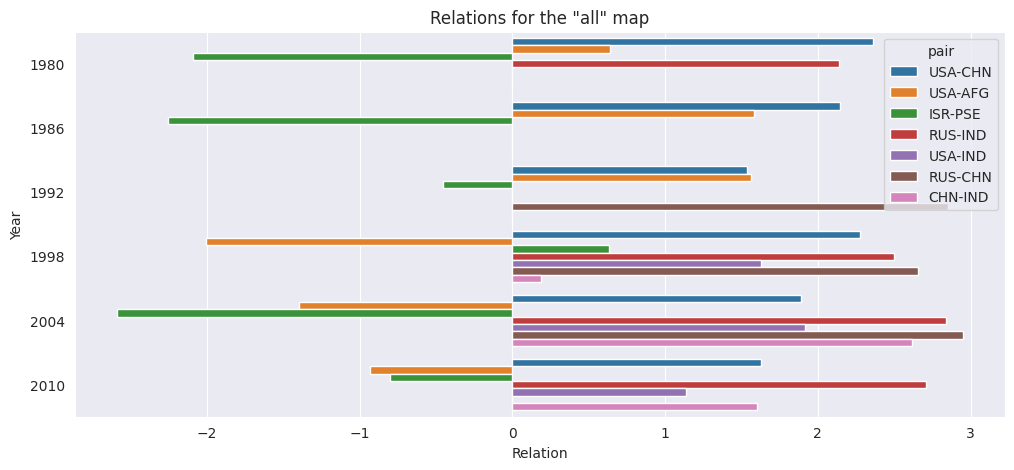

In [224]:
plt.figure(figsize=(12, 5))
sns.barplot(data=top, x='weight', y='year', hue='pair', orient='h')
plt.ylabel('Year')
plt.xlabel('Relation')
plt.title(f'Relations for the "{map_type}" map')
plt.show()

In [225]:
# Create source target pairs
selected_nations = ['USA', 'RUS', 'CHN', "ISR", "PSE", "AFG", "IRN", "IRQ"]
top_k = 10
selected_year = 1994
df_pair_noindex_st = df_pair_noindex.copy()
df_pair_noindex_st['P1'], df_pair_noindex_st['P2'] = df_pair_noindex['pair'].str.split('-', 1).str
df_pair_noindex_st = df_pair_noindex_st[df_pair_noindex_st['year'] == selected_year]
df_pair_noindex_st

/tmp/ipykernel_30119/2393875991.py:6: FutureWarning:

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

/tmp/ipykernel_30119/2393875991.py:6: FutureWarning:

Columnar iteration over characters will be deprecated in future releases.



,year,pair,weight,P1,P2
7,1994,IRL-GBR,1.898357,IRL,GBR
25,1994,IRL-IRN,0.000000,IRL,IRN
43,1994,IRL-USA,1.977665,IRL,USA
61,1994,GBR-USA,1.391919,GBR,USA
79,1994,GBR-LBY,-0.986850,GBR,LBY
...,...,...,...,...,...
54097,1994,IND-UGA,0.000000,IND,UGA
54115,1994,CZE-UZB,0.000000,CZE,UZB
54133,1994,CZE-UKR,0.000000,CZE,UKR
54151,1994,PRK-PAN,0.000000,PRK,PAN


In [226]:
import plotly.graph_objects as go

In [228]:
# For each year we select the worse 10 pairs
worst_k = 3
# Take every 5 years
worst_pairs = df_pair_noindex[df_pair_noindex['year'] % 1 == 0]
worst_pairs = worst_pairs.groupby('year').apply(lambda x: x.nsmallest(worst_k, 'weight'))
worst_pairs = worst_pairs.reset_index(drop=True)
# Sort by year
worst_pairs = worst_pairs.sort_values('year')


# Plot the worst pairs
fig = go.Figure()
# Take the first element for each year

for i in range(worst_k):
    values = []
    pairs = []
    for year in worst_pairs['year'].unique():
        worst_pairs_year = worst_pairs[worst_pairs['year'] == year]
        worst_pairs_year = worst_pairs_year.reset_index()
        values.append(worst_pairs_year['weight'][i])
        pairs.append(worst_pairs_year['pair'][i])
    fig.add_trace(go.Bar(x=years, y=values, text=pairs))
# Hide the legend
fig.update_layout(barmode='group', xaxis={'categoryorder':'array', 'categoryarray':years}, showlegend=False)
fig.show()
